# **Shlukování dat Audi used car listings**
Dataset obsahuje informace o ceně, převodovce, počtu ujetých mil, typu paliva, silniční dani, počtu ujetých mil na galon (mpg) a velikosti motoru.

* model: model auta.
* year: rok registrace.
* price: cena auta v eurech.
* transmission: druh převodovky.
* mileage: najeto mil.
* fuelType: typ paliva.
* tax road: silniční daň.
* mpg: mil na galon.
* engineSize: velikost motoru v litrech.

## Načtení knihoven

In [258]:
import pandas as pd # dataframes
import numpy as np # matrices and linear algebra
import matplotlib.pyplot as plt # plotting
import seaborn as sns # another matplotlib interface - styled and easier to use
import sklearn.preprocessing, sklearn.cluster, sklearn.metrics
from sklearn.cluster import AgglomerativeClustering

# Načteme si náš dataset do dataFramu z Pandasu

In [195]:
df = pd.read_csv('audi.csv', index_col=0)
df = df.reset_index()
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...
10663,A3,2020,16999,Manual,4018,Petrol,145,49.6,1.0
10664,A3,2020,16999,Manual,1978,Petrol,150,49.6,1.0
10665,A3,2020,17199,Manual,609,Petrol,150,49.6,1.0
10666,Q3,2017,19499,Automatic,8646,Petrol,150,47.9,1.4


# **Exploratory Data Analysis - EDA**

## Kontrola, jestli se v datasetu nacházejí duplikátní hodnoty

In [196]:
df.duplicated().sum()

103

## Odstranění duplikátních hodnot

In [197]:
df.drop_duplicates(inplace=True)
df = df.reset_index(drop=True)

In [198]:
df

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,A1,2017,12500,Manual,15735,Petrol,150,55.4,1.4
1,A6,2016,16500,Automatic,36203,Diesel,20,64.2,2.0
2,A1,2016,11000,Manual,29946,Petrol,30,55.4,1.4
3,A4,2017,16800,Automatic,25952,Diesel,145,67.3,2.0
4,A3,2019,17300,Manual,1998,Petrol,145,49.6,1.0
...,...,...,...,...,...,...,...,...,...
10560,A3,2020,16999,Manual,4018,Petrol,145,49.6,1.0
10561,A3,2020,16999,Manual,1978,Petrol,150,49.6,1.0
10562,A3,2020,17199,Manual,609,Petrol,150,49.6,1.0
10563,Q3,2017,19499,Automatic,8646,Petrol,150,47.9,1.4


# Podíváme se na datové typy sloupců v datasetu

In [199]:
df.dtypes

model            object
year              int64
price             int64
transmission     object
mileage           int64
fuelType         object
tax               int64
mpg             float64
engineSize      float64
dtype: object

## Podíváme se, jestli nám chybí nějaké hodnoty

In [200]:
df.isna().sum().sort_values(ascending=False)

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

Prázdné hodnoty se v datasetu nevyskytují, ale ještě je potřeba zkontrolovat hodnoty s 0.

In [201]:
df.shape

(10565, 9)

In [202]:
df.describe(include=np.number)

,year,price,mileage,tax,mpg,engineSize
count,10565.000000,10565.000000,10565.000000,10565.000000,10565.000000,10565.000000
mean,2017.084524,22853.956081,24955.960530,125.909134,50.837558,1.932977
std,2.167309,11723.076767,23448.942551,67.408761,12.963337,0.602902
min,1997.000000,1490.000000,1.000000,0.000000,18.900000,0.000000
25%,2016.000000,15000.000000,6000.000000,125.000000,40.900000,1.500000
50%,2017.000000,20000.000000,19268.000000,145.000000,49.600000,2.000000
75%,2019.000000,27990.000000,36668.000000,145.000000,58.900000,2.000000
max,2020.000000,145000.000000,323000.000000,580.000000,188.300000,6.300000


Jak můžeme vidět, v datasetu se nachází nulové hodnoty a to pro daň a velikost motoru.

In [203]:
df["engineSize"]=df["engineSize"].replace(0,np.nan)
df["tax"]=df["tax"].replace(0,np.nan)

Změníme je na nan. A podíváme se znova na chybějící hodnoty

In [204]:
df.isna().sum().sort_values(ascending=False)

tax             534
engineSize       52
model             0
year              0
price             0
transmission      0
mileage           0
fuelType          0
mpg               0
dtype: int64

## Odstranění chybějících hodnot

In [205]:
df.dropna(inplace = True)
df.isna().sum().sort_values(ascending=False)

model           0
year            0
price           0
transmission    0
mileage         0
fuelType        0
tax             0
mpg             0
engineSize      0
dtype: int64

In [206]:
df = df.reset_index(drop=True)

## Popis kategorických sloupců

In [207]:
categorical_columns = ['model', 'transmission', 'fuelType']
df[categorical_columns].describe()

,model,transmission,fuelType
count,9979,9979,9979
unique,26,3,3
top,A3,Manual,Diesel
freq,1780,3821,5148


V datasetu jsou tři sloupce, které jsou kategorické. Ty budeme muset později zakódovat na číselné hodnoty.

# Podíváme se jak data spolu korelují

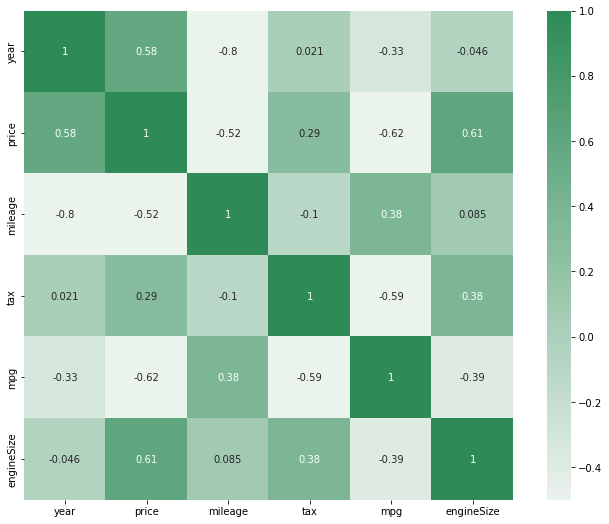

In [208]:
df_corr = df.corr()
plt.figure(figsize=(12, 9))
sns.heatmap(df_corr, square=True, cmap=sns.light_palette("seagreen", as_cmap=True), vmin=-0.5, annot=True)

Z korelační matice lze vyčíst, že hodnoty price a year spolu korelují. Dále pák je korelace i u price s mileage a také cenu zvedá i velikost motoru.

## Zastoupení aut podle data registrace

Text(0.5, 1.0, 'Počet aut podle roku')

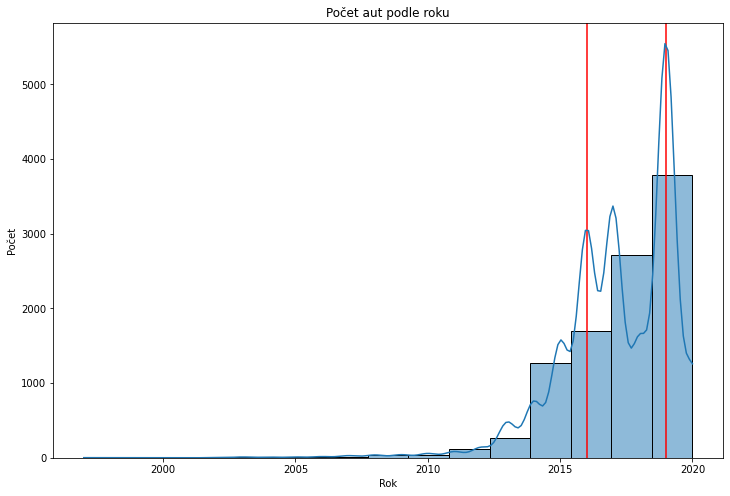

In [132]:
fig = plt.figure(figsize=(12,8))
plt.xlabel('Rok')
plt.ylabel('Počet')
plt.axvline(df.year.quantile(0.25),color='red')
plt.axvline(df.year.quantile(0.75),color='red')
sns.histplot(df.year,bins=15,kde=True).set_title('Počet aut podle roku')

Naprostá většina aut je v rozmezí let 2016 - 2019. Úplně nejvíc je pak aut registrovaných v roce 2020.

## Zastoupení aut podle jeho ceny

Text(0.5, 1.0, 'Počet aut podle ceny')

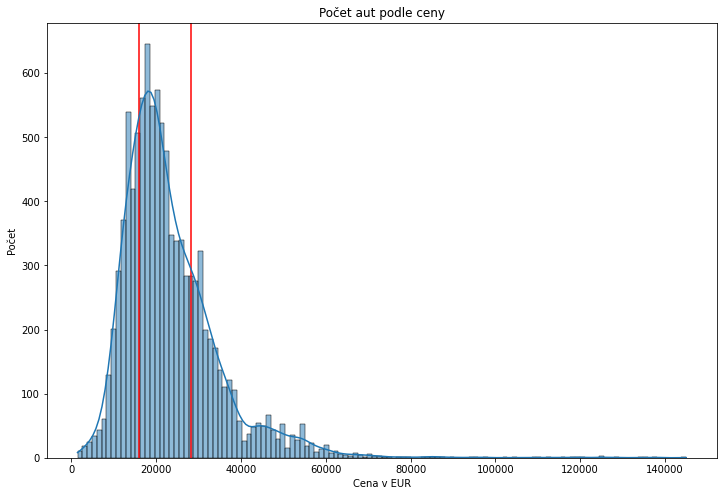

In [133]:
fig = plt.figure(figsize=(12,8))
plt.xlabel('Cena v EUR')
plt.ylabel('Počet')
plt.axvline(df.price.quantile(0.25),color='red')
plt.axvline(df.price.quantile(0.75),color='red')
sns.histplot(df.price,kde=True).set_title('Počet aut podle ceny')

Nejvíce aut se prodává kolem 20000 euro.

## Zastoupení aut podle typu převodovky

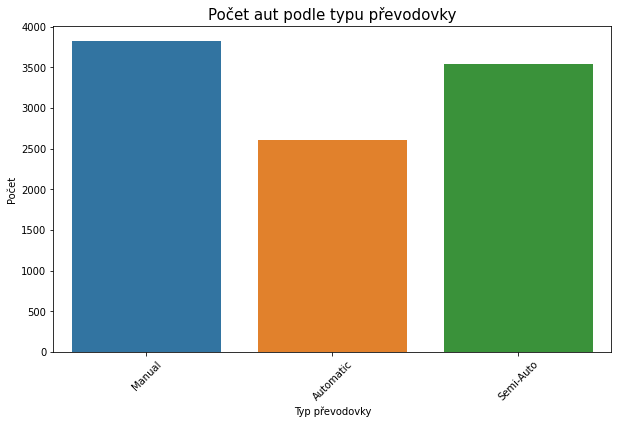

In [134]:
plt.figure(figsize=(10,6))
s =sns.countplot(x = df.transmission)
s.set_xticklabels(s.get_xticklabels(),rotation=45)
plt.title("Počet aut podle typu převodovky", size=15)
plt.xlabel('Typ převodovky')
plt.ylabel('Počet')
plt.show()

Nejvíce aut je s manuální převodovkou, ale v těsném závěsu jsou hned auta s poloautomatickou převodovkou. Nejméně aut je s automatickou převodovkou a to cca 2500.

## Zastoupení aut podle velikosti motoru

Text(0.5, 1.0, 'Velikost motoru v litrech')

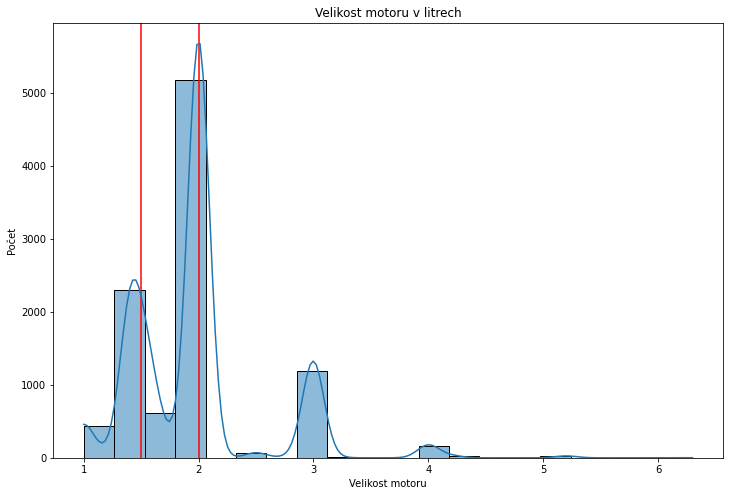

In [135]:
fig = plt.figure(figsize=(12,8))
plt.xlabel('Velikost motoru')
plt.ylabel('Počet')
plt.axvline(df.engineSize.quantile(0.25),color='red')
plt.axvline(df.engineSize.quantile(0.75),color='red')
sns.histplot(df.engineSize,bins=20,kde=True).set_title('Velikost motoru v litrech')

Nejvíce aut je dvou litrových. Nejmenší zastoupení má pětilitr, to bude patřit mezi sportovní a nejdražší auta.

## Zastoupení aut podle ujeté vzdálenosti

Text(0.5, 1.0, 'Najetých mil')

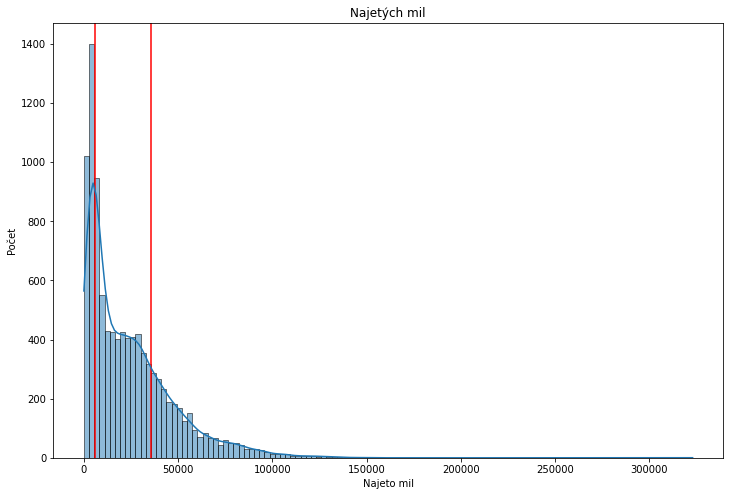

In [136]:
fig = plt.figure(figsize=(12,8))
plt.xlabel('Najeto mil')
plt.ylabel('Počet')
plt.axvline(df.mileage.quantile(0.25),color='red')
plt.axvline(df.mileage.quantile(0.75),color='red')
sns.histplot(df.mileage,kde=True).set_title('Najetých mil')

Nejvíce aut má nájezd do 30000 mil

## Zastoupení aut podle typu paliva

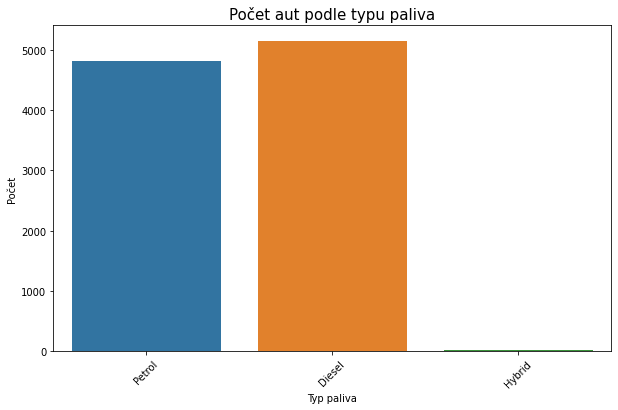

In [137]:
plt.figure(figsize=(10,6))
s =sns.countplot(x = df.fuelType)
s.set_xticklabels(s.get_xticklabels(),rotation=45)
plt.title("Počet aut podle typu paliva", size=15)
plt.xlabel('Typ paliva')
plt.ylabel('Počet')
plt.show()

Nejvíce je naftových aut a to cca 5000 ale jen o něco málo je benzínových aut. Naprosté minimum je pak hybridních.

## Která jsou nejdražší auta

In [138]:
the_most_expensive = df.sort_values(by="price", ascending=False)
the_most_expensive

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
4783,R8,2020,145000,Semi-Auto,2000,Petrol,145.0,21.1,5.2
2255,R8,2020,137995,Semi-Auto,70,Petrol,145.0,21.1,5.2
4179,R8,2019,137500,Semi-Auto,10,Petrol,150.0,21.4,5.2
3367,R8,2019,135000,Automatic,1000,Petrol,145.0,32.8,5.2
5459,R8,2020,133900,Semi-Auto,333,Petrol,145.0,21.4,5.2
...,...,...,...,...,...,...,...,...,...
9822,A6,2008,2490,Manual,323000,Diesel,200.0,44.1,2.0
10108,TT,2002,1990,Manual,131925,Petrol,325.0,30.1,1.8
7795,A3,2005,1975,Manual,104000,Petrol,240.0,38.1,2.0
10552,A4,2004,1699,Manual,110000,Diesel,315.0,36.2,2.5


Nejdražší auta jsou sportovní R8.

## Průměrná cena auta podle roku

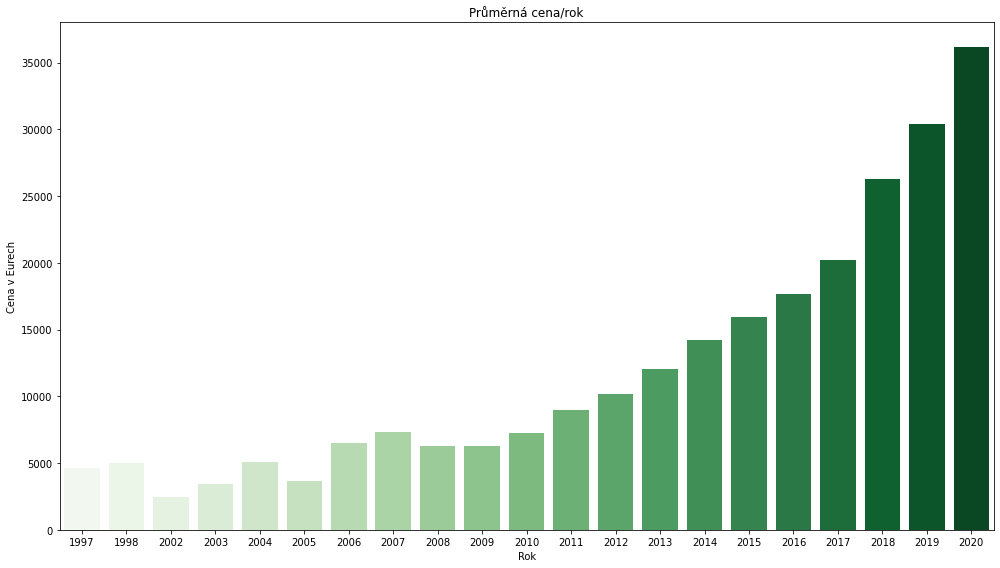

In [139]:
year_price = df.groupby('year')['price'].mean().sort_values()

plt.figure(figsize=(14, 8))
plt.title("Průměrná cena/rok")
pal = sns.color_palette("Greens", len(year_price))

sns.barplot(x=year_price.index, y=year_price.values, palette=pal)

plt.xlabel("Rok")
plt.ylabel("Cena v Eurech")
plt.tight_layout()

Jak už jsme vypozorovali u korelační matice, cena vozu klesá s jeho stářím.

## Průměrná cena auta podle jednotlivých modelů

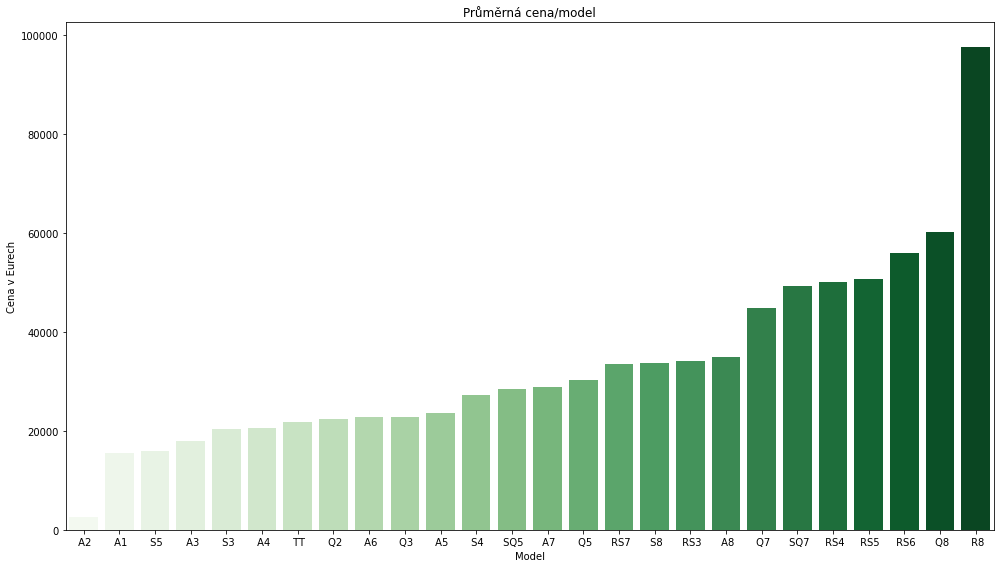

In [140]:
model_price = df.groupby('model')['price'].mean().sort_values()

plt.figure(figsize=(14, 8))
plt.title("Průměrná cena/model")
pal = sns.color_palette("Greens", len(model_price))

sns.barplot(x=model_price.index, y=model_price.values, palette=pal)

plt.xlabel("Model")
plt.ylabel("Cena v Eurech")
plt.tight_layout()

Mezi nejdražší vozy patří sportovní a SUV vozy s velkým výkonem.

## Kolik aut má každý model

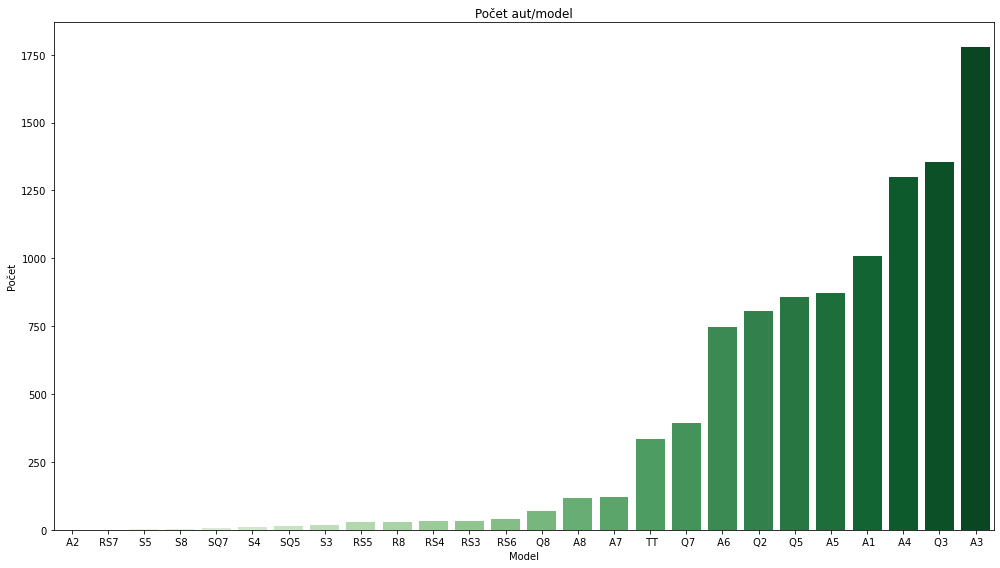

In [141]:
model_count = df.groupby('model')['model'].count().sort_values()

plt.figure(figsize=(14, 8))
plt.title("Počet aut/model")
pal = sns.color_palette("Greens", len(model_count))

sns.barplot(x=model_count.index, y=model_count.values, palette=pal)

plt.xlabel("Model")
plt.ylabel("Počet")
plt.tight_layout()

Mezi nejpočetnější modely patří ty levnější auta jako jsou A3, Q3, A4.

## Jak souvísí cena auta s rokem registrace

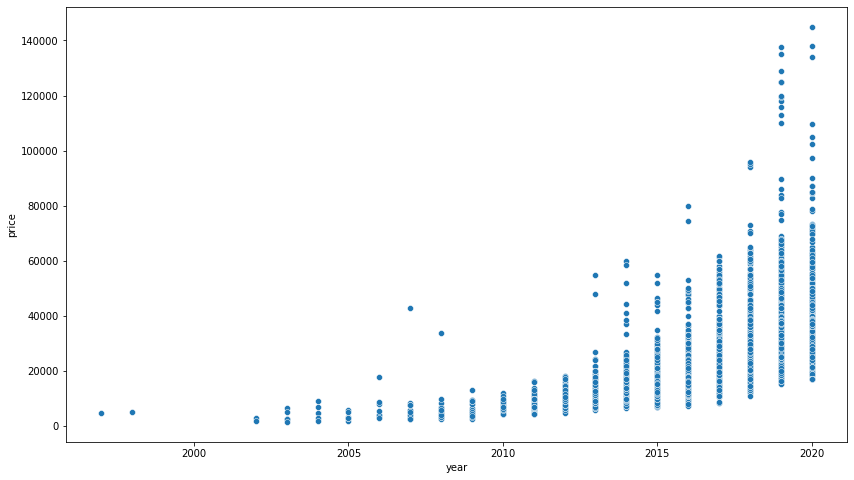

In [142]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=df['year'], y=df['price'])

Na grafu vidíme jak cena klesá se stářím vozu.

## Jak souvísí cena auta s nájezdem mil.

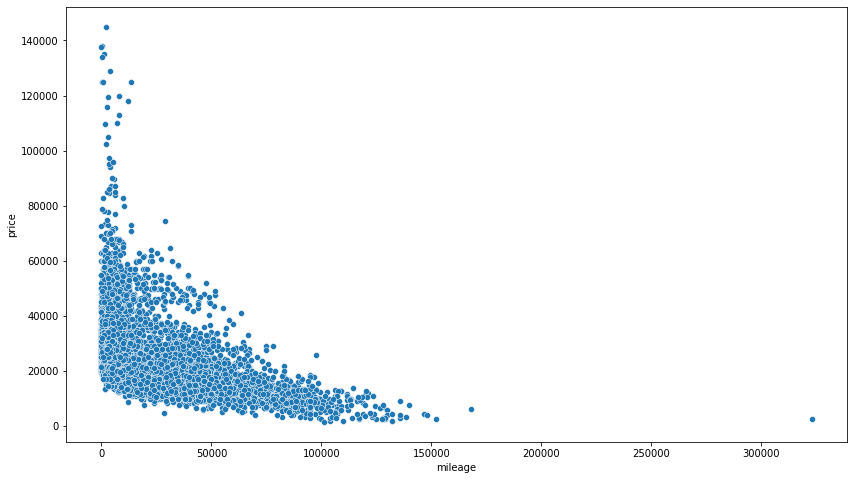

In [143]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=df['mileage'], y=df['price'])

Vidíme, že cena klesá s počtem najetých mil

## Jak souvísí cena auta s velikostí motoru

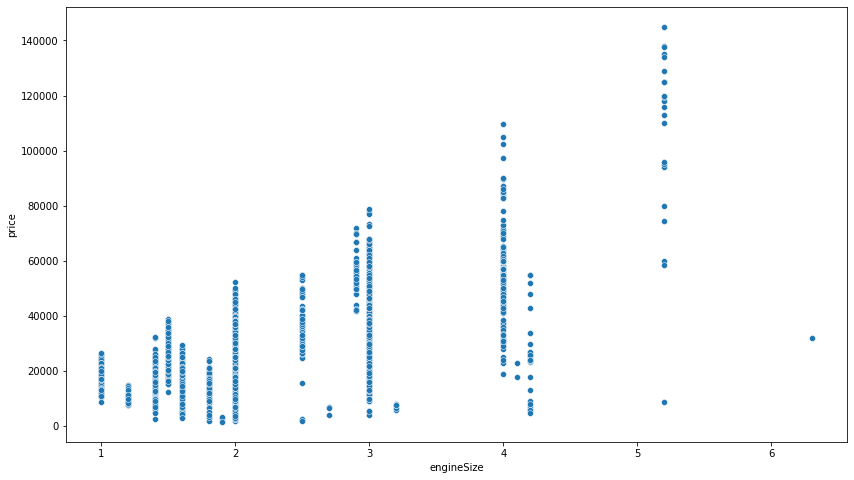

In [144]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=df['engineSize'], y=df['price'])

Z grafu lze vidět, že cena vozu roste i s velikostí motoru.

# **Shlukování dat**

## Předzpracování dat

Pro číselné hodnoty použijeme Min-Max scaling a pro kategorické One-hot encoding

## Min-Max scaling

Min-Max jsem použil, aby rozptyl hodnot nebyl tak velký.

In [209]:
df_only_numeric = df.select_dtypes(np.number)
X = df_only_numeric.values
scaler = sklearn.preprocessing.MinMaxScaler()
X_min_max_scaled = scaler.fit_transform(X)
X_min_max_scaled

array([[0.86956522, 0.07671939, 0.04871223, 0.23214286, 0.26449275,
        0.0754717 ],
       [0.82608696, 0.10459201, 0.11208084, 0.        , 0.32826087,
        0.18867925],
       [0.82608696, 0.06626716, 0.09270927, 0.01785714, 0.26449275,
        0.0754717 ],
       ...,
       [1.        , 0.10946276, 0.00188236, 0.23214286, 0.22246377,
        0.        ],
       [0.86956522, 0.12548951, 0.02676479, 0.23214286, 0.21014493,
        0.0754717 ],
       [0.82608696, 0.10110097, 0.0366998 , 0.23214286, 0.21014493,
        0.0754717 ]])

In [210]:
df_scaled = pd.DataFrame(X_min_max_scaled, columns=df_only_numeric.columns)
df_scaled

,year,price,mileage,tax,mpg,engineSize
0,0.869565,0.076719,0.048712,0.232143,0.264493,0.075472
1,0.826087,0.104592,0.112081,0.000000,0.328261,0.188679
2,0.826087,0.066267,0.092709,0.017857,0.264493,0.075472
3,0.869565,0.106682,0.080344,0.223214,0.350725,0.188679
4,0.956522,0.110167,0.006183,0.223214,0.222464,0.000000
...,...,...,...,...,...,...
9974,1.000000,0.108069,0.012437,0.223214,0.222464,0.000000
9975,1.000000,0.108069,0.006121,0.232143,0.222464,0.000000
9976,1.000000,0.109463,0.001882,0.232143,0.222464,0.000000
9977,0.869565,0.125490,0.026765,0.232143,0.210145,0.075472


## One-hot encoding

In [211]:
df.describe(exclude=np.number)

,model,transmission,fuelType
count,9979,9979,9979
unique,26,3,3
top,A3,Manual,Diesel
freq,1780,3821,5148


Pro one-hot encoding jsem použil get_dummies(), je to nejjednodušší způsob. Tenhle typ kódování jsem použil, protože nezálaží na pořadí.

In [212]:
df_scaled = pd.concat([df_scaled,pd.get_dummies(df.fuelType, prefix='fuelType')],axis=1)

In [213]:
df_scaled = pd.concat([df_scaled,pd.get_dummies(df.transmission, prefix='transmission')],axis=1)

In [214]:
df_scaled = pd.concat([df_scaled,pd.get_dummies(df.model, prefix='model')],axis=1)

In [215]:
pd.set_option('display.max_columns', None)
df_scaled

,year,price,mileage,tax,mpg,engineSize,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,model_ A1,model_ A2,model_ A3,model_ A4,model_ A5,model_ A6,model_ A7,model_ A8,model_ Q2,model_ Q3,model_ Q5,model_ Q7,model_ Q8,model_ R8,model_ RS3,model_ RS4,model_ RS5,model_ RS6,model_ RS7,model_ S3,model_ S4,model_ S5,model_ S8,model_ SQ5,model_ SQ7,model_ TT
0,0.869565,0.076719,0.048712,0.232143,0.264493,0.075472,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.826087,0.104592,0.112081,0.000000,0.328261,0.188679,1,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.826087,0.066267,0.092709,0.017857,0.264493,0.075472,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.869565,0.106682,0.080344,0.223214,0.350725,0.188679,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0.956522,0.110167,0.006183,0.223214,0.222464,0.000000,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,1.000000,0.108069,0.012437,0.223214,0.222464,0.000000,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9975,1.000000,0.108069,0.006121,0.232143,0.222464,0.000000,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9976,1.000000,0.109463,0.001882,0.232143,0.222464,0.000000,0,0,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
9977,0.869565,0.125490,0.026765,0.232143,0.210145,0.075472,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Kontrola typů

Kontrola jestli všechny sloupce jsou číselné.

In [216]:
df_scaled.dtypes

year                      float64
price                     float64
mileage                   float64
tax                       float64
mpg                       float64
engineSize                float64
fuelType_Diesel             uint8
fuelType_Hybrid             uint8
fuelType_Petrol             uint8
transmission_Automatic      uint8
transmission_Manual         uint8
transmission_Semi-Auto      uint8
model_ A1                   uint8
model_ A2                   uint8
model_ A3                   uint8
model_ A4                   uint8
model_ A5                   uint8
model_ A6                   uint8
model_ A7                   uint8
model_ A8                   uint8
model_ Q2                   uint8
model_ Q3                   uint8
model_ Q5                   uint8
model_ Q7                   uint8
model_ Q8                   uint8
model_ R8                   uint8
model_ RS3                  uint8
model_ RS4                  uint8
model_ RS5                  uint8
model_ RS6    

Kontrola jestli se v dataframu nenachází prázdná hodnota. Často se to stane pokud z dataframe něco odstraňujeme a nezavoláme reset_index.

In [217]:
np.isnan(df_scaled)

,year,price,mileage,tax,mpg,engineSize,fuelType_Diesel,fuelType_Hybrid,fuelType_Petrol,transmission_Automatic,transmission_Manual,transmission_Semi-Auto,model_ A1,model_ A2,model_ A3,model_ A4,model_ A5,model_ A6,model_ A7,model_ A8,model_ Q2,model_ Q3,model_ Q5,model_ Q7,model_ Q8,model_ R8,model_ RS3,model_ RS4,model_ RS5,model_ RS6,model_ RS7,model_ S3,model_ S4,model_ S5,model_ S8,model_ SQ5,model_ SQ7,model_ TT
0,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9974,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9975,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9976,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
9977,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False


# Pro shlukování použijeme K-Means algoritmus a Elbow metodu

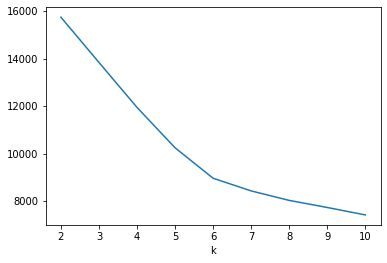

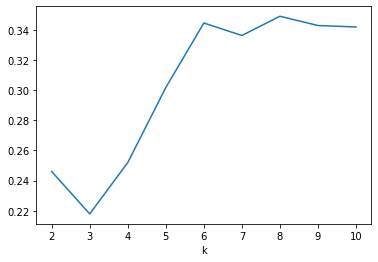

In [218]:
clustering_scores = []
for k in range(2, 11):
    clustering = sklearn.cluster.KMeans(n_clusters=k).fit(df_scaled)
    clustering_scores.append({
        'k': k,
        'sse': clustering.inertia_,
        'silhouette': sklearn.metrics.silhouette_score(df_scaled, clustering.labels_)
    })
df_clustering_scores = pd.DataFrame.from_dict(clustering_scores, orient='columns')
df_clustering_scores = df_clustering_scores.set_index('k')
df_clustering_scores.sse.plot()
plt.figure()
df_clustering_scores.silhouette.plot()

Použijeme K-means pro 6 clusterů

In [219]:
clustering = sklearn.cluster.KMeans(n_clusters=6)
clustering.fit(df_scaled)

KMeans(n_clusters=6)

## Kolik hodnot mají jednotlivé clustery

In [220]:
pd.Series(clustering.labels_).value_counts()

0    2055
2    1779
3    1768
4    1766
1    1616
5     995
dtype: int64

Až na páty cluster mají podobný počet hodnot

## Přidání id clusteru zpátky do původního datasetu

In [221]:
df['cluster_id'] = clustering.labels_
df.head()

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,cluster_id
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,0
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,1
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,0
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,1
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,0


## Pro jednotlivé clustery se podíváme na numerické a kategorické hodnoty

In [223]:
with pd.option_context('display.max_columns', None):
    display(df.groupby('cluster_id').describe())

year                                                         \
             count         mean       std     min     25%     50%     75%   
cluster_id                                                                  
0           2055.0  2016.813139  2.153352  2002.0  2016.0  2017.0  2018.0   
1           1616.0  2017.407178  2.173308  2003.0  2016.0  2019.0  2019.0   
2           1779.0  2017.400225  1.832564  2008.0  2016.0  2017.0  2019.0   
3           1768.0  2017.907240  1.619908  2010.0  2017.0  2018.0  2019.0   
4           1766.0  2016.077010  2.323123  2003.0  2015.0  2016.0  2017.0   
5            995.0  2017.635176  2.495180  1997.0  2017.0  2019.0  2019.0   

                     price                                                \
               max   count          mean           std     min       25%   
cluster_id                                                                 
0           2020.0  2055.0  17107.628224   5425.672107  1975.0  13182.50   
1           2020.0  1616.0  28558.878713  12954.426443  1490.0  18493.75   
2           2020.0  1779.0  27996.202923  12388.647645  4995.0  19457.50   
3           2020.0  1768.0  26413.428167  11465.079761  6995.0  20393.25   
4           2020.0  1766.0  16136.096829   5289.797512  1699.0  12500.00   
5           2020.0   995.0  27757.373869  13687.219642  3495.0  20708.00   

                                        mileage                              \
                50%       75%       max   count          mean           std   
cluster_id                                                                    
0           16595.0  19990.00   47995.0  2055.0  22740.873966  18406.339279   
1           26878.0  34985.00   89750.0  1616.0  24503.690594  26448.017919   
2           24500.0  33770.00   89990.0  1779.0  23998.600899  20460.648749   
3           23996.5  30768.75  145000.0  1768.0  15740.265271  14455.242218   
4           15995.0  19367.50   37995.0  1766.0  38189.474519  29534.887478   
5           25999.0  31508.00  135000.0   995.0  16431.249246  18574.657575   

                                                           tax              \
             min      25%      50%       75%       max   count        mean   
cluster_id                                                                   
0           10.0   8668.5  20052.0  30820.00  139989.0  2055.0  119.233577   
1            1.0   5000.0  11000.0  39323.75  136000.0  1616.0  146.930693   
2           10.0   5767.0  19588.0  38000.00  105200.0  1779.0  142.653176   
3           10.0   4500.0  11000.0  24073.25   98386.0  1768.0  146.102941   
4            5.0  15082.0  33781.5  54959.75  323000.0  1766.0   96.500566   
5            7.0   4127.5   9161.0  22524.50  122000.0   995.0  158.552764   

                                                            mpg             \
                  std   min    25%    50%    75%    max   count       mean   
cluster_id                                                                   
0           62.696111  20.0   30.0  145.0  145.0  570.0  2055.0  51.007153   
1           51.885658  20.0  145.0  145.0  145.0  570.0  1616.0  48.687933   
2           49.981870  20.0  145.0  145.0  150.0  555.0  1779.0  50.356155   
3           52.362949  20.0  145.0  145.0  150.0  570.0  1768.0  42.877093   
4           63.957641  20.0   30.0  145.0  145.0  325.0  1766.0  59.172197   
5           77.295950  20.0  145.0  145.0  150.0  580.0   995.0  40.531759   

                                                     engineSize            \
                  std   min   25%   50%   75%    max      count      mean   
cluster_id                                                                  
0            7.490427  19.6  47.1  51.4  55.4   70.6     2055.0  1.459805   
1           10.530044  28.5  39.2  47.9  54.3  117.7     1616.0  2.341522   
2           11.268828  28.5  42.8  49.6  57.6  156.9     1779.0  2.318775   
3            9.228856  21.1  36.1  41.5  47.9  141.3   

In [224]:
with pd.option_context('display.max_columns', None):
    display(df.groupby('cluster_id').describe(include='O'))

model                  transmission                          \
           count unique  top freq        count unique        top  freq   
cluster_id                                                               
0           2055     12   A1  627         2055      1     Manual  2055   
1           1616     15   A6  278         1616      1  Automatic  1616   
2           1779     15   Q5  355         1779      1  Semi-Auto  1779   
3           1768     18   A3  387         1768      1  Semi-Auto  1768   
4           1766     11   A3  482         1766      1     Manual  1766   
5            995     23   A3  183          995      1  Automatic   995   

           fuelType                       
              count unique     top  freq  
cluster_id                                
0              2055      1  Petrol  2055  
1              1616      2  Diesel  1612  
2              1779      2  Diesel  1770  
3              1768      2  Petrol  1766  
4              1766      1  Diesel  1766  
5               995      1  Petrol   995

## Cenové rozložení v jednotlivých clusterech

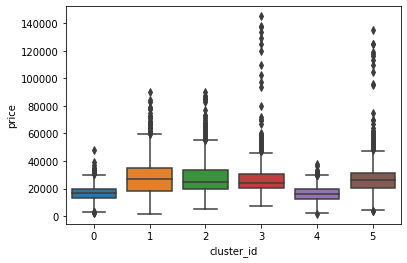

In [225]:
sns.boxplot(data=df, y="price",x="cluster_id")

Všechny clustery mají dost odlehlých hodnot. Nejlevnější auta jsou v clusterech 0 a 4. Medián v 1. 2. 3. a pátem clusteru je podobný.

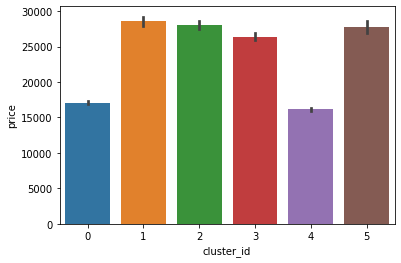

In [243]:
sns.barplot(data=df, y="price",x="cluster_id")

V tom grafu je jasně vidět to co bylo popsáno výše.

## Rok registrace auta podle clusterů

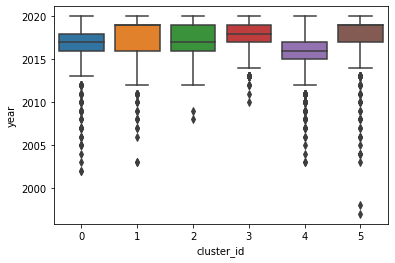

In [226]:
sns.boxplot(data=df, y="year",x="cluster_id")

Opět spoustu odlehlých hodnot. Tady můžeme vidět, že nejstarší auta jsou v 0. a 4. clustery. Ty také patří mezi nejlevnější. Páty cluster má nejstarší auta a patři mezi ty dražší, může být způsobeno nějakým veteránem, což zvedá jeho cenu.

## Počet najetých mil podle clusterů

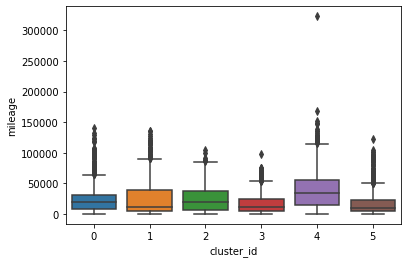

In [227]:
sns.boxplot(data=df, y="mileage",x="cluster_id")

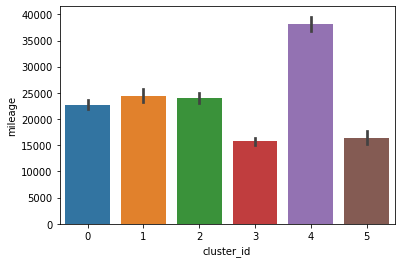

In [245]:
sns.barplot(data=df, y="mileage",x="cluster_id")

Nejméně má najeto 3. cluster ten taky patří k těm dražším autům. Nejvíce má najeto 4. cluster a ten patří mezi ta nejlevnější auta.

## Silniční daň podle clusterů

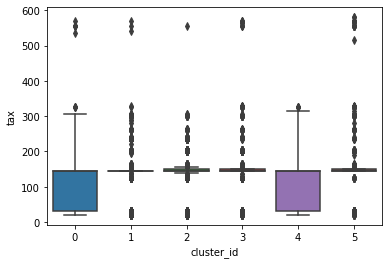

In [228]:
sns.boxplot(data=df, y="tax",x="cluster_id")
plt.xlabel('Country Groups', fontsize=10)
plt.ylabel('Income per person', fontsize=10)
plt.title('Income per person of all the Country Groups')
plt.show()

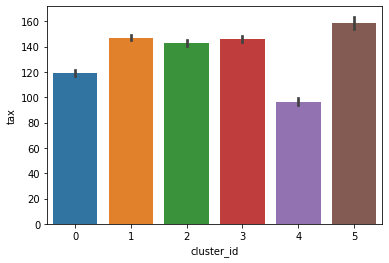

In [246]:
sns.barplot(data=df, y="tax",x="cluster_id")

Opět vidíme, že nejlevnější daň má 4. cluster ve, kterém jsou levná auta. Nejdražší je 5. cluster, který obsahuje drahé auta.

## Velikost motoru podle clusterů

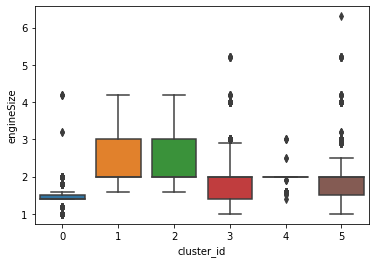

In [230]:
sns.boxplot(data=df, y="engineSize",x="cluster_id")

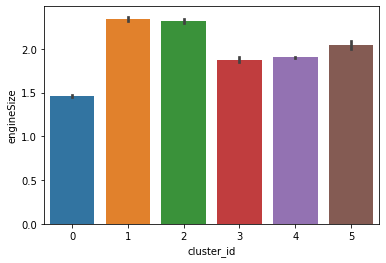

In [247]:
sns.barplot(data=df, y="engineSize",x="cluster_id")

1. a 2. cluster jsou si podobné. V nultém clusteru jsou převážně auto 1,5 l. Ve 4. jsou auta do 3l. 3. a 5. cluster patří mezi ty dražší, proto v něm jsou auta s 5l a 6l.

## Jednotlivé modely v clusterech

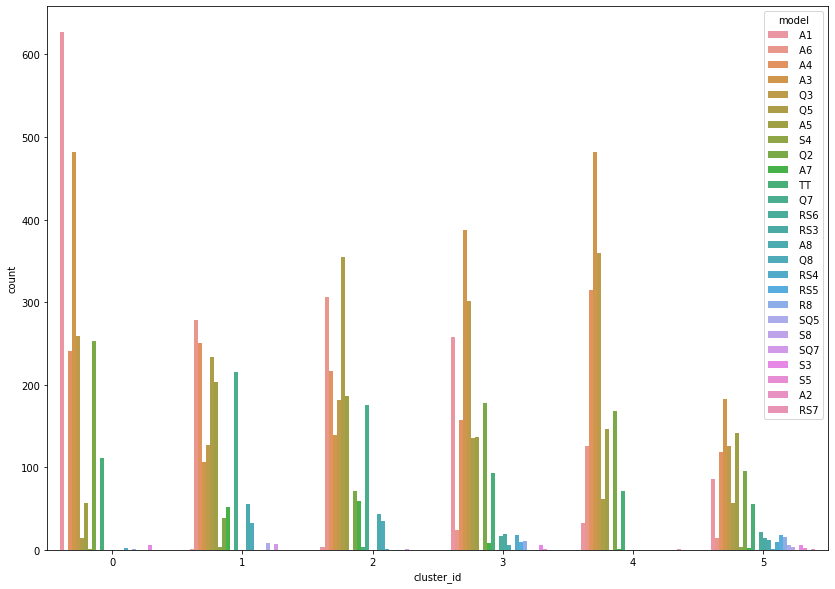

In [240]:
plt.figure(figsize=(14,10))
sns.countplot(data=df, x="cluster_id", hue="model")

Vidíme, že v 0. clusteru jsou modely jako A1, A3, které jsou ty levnější. A3 převažuje i ve 4. clustery, který patří taky mezi ty nejlevnější. Do 3. a 5. spadají převážně ty luxusnější vozy, tyto clustery taky patří k těm dražším.

## Typy paliv v clusterech

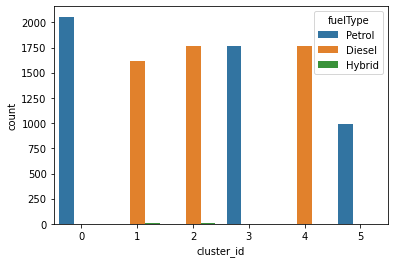

In [237]:
sns.countplot(data=df, x="cluster_id", hue="fuelType")

Z grafu lze vidět, že v nultém clusteru jsou ta levná auta ale benzínová. Ve 4. jsou opět ta levná ale naftová.  3. a 5. jsou luxusnější vozidla ale na benzín. V 1. a 2. jsou dražší auta ale na naftu a objevují se tam i hybridná vozy.

## Typy převodovek v clusterech

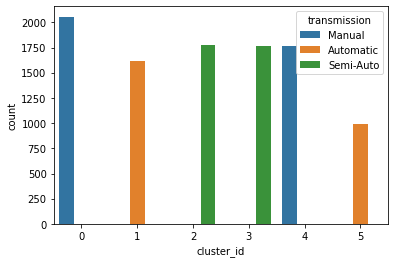

In [238]:
sns.countplot(data=df, x="cluster_id", hue="transmission")

V 0. a 4. jsou levná auta a ta také mají manuální převodovku, která je levnější. V 5. jsou auta s automatem a na benzín. Ve 3. je poloautomat na benzín. V 2. je poloautomat na naftu. A v 1. automat na naftu.

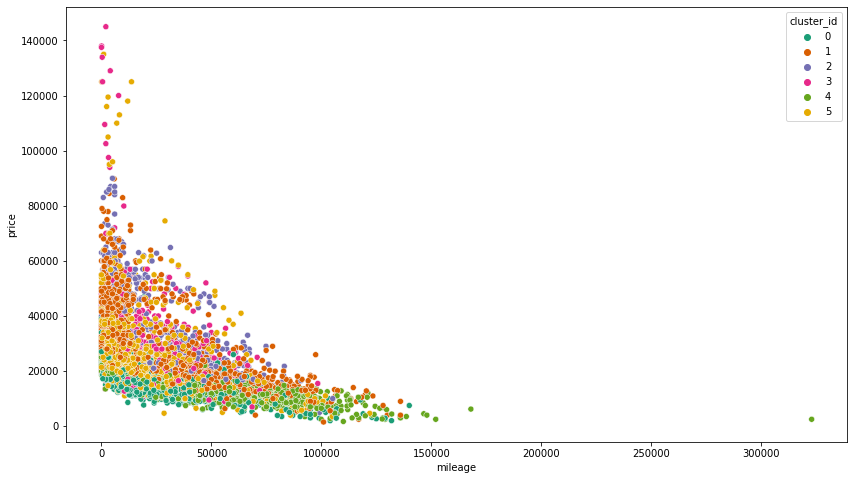

In [256]:
plt.figure(figsize=(14,8))
sns.scatterplot(x=df['mileage'], y=df['price'], data=df, hue='cluster_id',palette="Dark2")

Tady je vidět, jak cluster 0 a 4 patři mezi ty nejlevnější a to bez ohledu na to kolik mají najeto.

## Agglomerative clustering

In [287]:
clustering = AgglomerativeClustering(linkage='ward', distance_threshold=40, n_clusters=None)
clustering = clustering.fit(df_scaled)
pd.Series(clustering.labels_).value_counts()

0    2055
1    1774
3    1771
2    1766
4    1611
5    1002
dtype: int64

Agglomerative clustering mi vrací téměř početně totožné clustery.

In [288]:
df_agg = df

Přidání id clusteru do dataframu

In [289]:
df_agg['cluster_id'] = clustering.labels_
df_agg

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize,cluster_id
0,A1,2017,12500,Manual,15735,Petrol,150.0,55.4,1.4,0
1,A6,2016,16500,Automatic,36203,Diesel,20.0,64.2,2.0,4
2,A1,2016,11000,Manual,29946,Petrol,30.0,55.4,1.4,0
3,A4,2017,16800,Automatic,25952,Diesel,145.0,67.3,2.0,4
4,A3,2019,17300,Manual,1998,Petrol,145.0,49.6,1.0,0
...,...,...,...,...,...,...,...,...,...,...
9974,A3,2020,16999,Manual,4018,Petrol,145.0,49.6,1.0,0
9975,A3,2020,16999,Manual,1978,Petrol,150.0,49.6,1.0,0
9976,A3,2020,17199,Manual,609,Petrol,150.0,49.6,1.0,0
9977,Q3,2017,19499,Automatic,8646,Petrol,150.0,47.9,1.4,5


## Pro jednotlivé clustery se podíváme na numerické a kategorické hodnoty

In [290]:
with pd.option_context('display.max_columns', None):
    display(df_agg.groupby('cluster_id').describe())

year                                                         \
             count         mean       std     min     25%     50%     75%   
cluster_id                                                                  
0           2055.0  2016.813139  2.153352  2002.0  2016.0  2017.0  2018.0   
1           1774.0  2017.927283  1.614168  2010.0  2017.0  2018.0  2019.0   
2           1766.0  2016.077010  2.323123  2003.0  2015.0  2016.0  2017.0   
3           1771.0  2017.389610  1.830558  2008.0  2016.0  2017.0  2019.0   
4           1611.0  2017.403476  2.174348  2003.0  2016.0  2019.0  2019.0   
5           1002.0  2017.619760  2.494776  1997.0  2017.0  2019.0  2019.0   

                     price                                               \
               max   count          mean           std     min      25%   
cluster_id                                                                
0           2020.0  2055.0  17107.628224   5425.672107  1975.0  13182.5   
1           2020.0  1774.0  26577.646561  11559.667003  6995.0  20450.0   
2           2020.0  1766.0  16136.096829   5289.797512  1699.0  12500.0   
3           2020.0  1771.0  27900.918125  12355.378674  4995.0  19420.5   
4           2020.0  1611.0  28523.692117  12938.557340  1490.0  18492.5   
5           2020.0  1002.0  27705.570858  13654.441461  3495.0  20680.0   

                                       mileage                              \
                50%      75%       max   count          mean           std   
cluster_id                                                                   
0           16595.0  19990.0   47995.0  2055.0  22740.873966  18406.339279   
1           24077.5  30984.0  145000.0  1774.0  15604.337091  14420.293977   
2           15995.0  19367.5   37995.0  1766.0  38189.474519  29534.887478   
3           24500.0  33492.5   89990.0  1771.0  24058.988707  20438.569102   
4           26850.0  34949.0   89750.0  1611.0  24557.598386  26470.348566   
5           25950.0  31490.0  135000.0  1002.0  16583.336327  18628.975048   

                                                            tax              \
             min       25%      50%       75%       max   count        mean   
cluster_id                                                                    
0           10.0   8668.50  20052.0  30820.00  139989.0  2055.0  119.233577   
1           10.0   4456.25  10858.5  23931.50   98386.0  1774.0  145.851184   
2            5.0  15082.00  33781.5  54959.75  323000.0  1766.0   96.500566   
3           10.0   5835.00  19681.0  38062.00  105200.0  1771.0  142.619989   
4            1.0   5000.00  11000.0  39355.50  136000.0  1611.0  147.036002   
5            7.0   4220.25   9282.0  22703.00  122000.0  1002.0  158.777445   

                                                            mpg             \
                  std   min    25%    50%    75%    max   count       mean   
cluster_id                                                                   
0           62.696111  20.0   30.0  145.0  145.0  570.0  2055.0  51.007153   
1           52.159052  20.0  145.0  145.0  150.0  570.0  1774.0  43.453269   
2           63.957641  20.0   30.0  145.0  145.0  325.0  1766.0  59.172197   
3           50.176768  20.0  145.0  145.0  150.0  555.0  1771.0  50.004235   
4           51.866838  20.0  145.0  145.0  145.0  570.0  1611.0  48.501862   
5           77.128325  20.0  145.0  145.0  150.0  580.0  1002.0  40.537924   

                                                       engineSize            \
                  std   min     25%   50%   75%    max      count      mean   
cluster_id                                                                    
0            7.490427  19.6  47.100  51.4  55.4   70.6     2055.0  1.459805   
1           11.390653  21.1  36.325  41.5  47.9  156.9     1774.0  1.878974   
2            8.717859  29.7  51.400  61.4  67.3   80.7     1766.0  1.905776   
3           10.039905  28.5  42.200  49.6  56.5   74

In [291]:
with pd.option_context('display.max_columns', None):
    display(df.groupby('cluster_id').describe(include='O'))

model                  transmission                          \
           count unique  top freq        count unique        top  freq   
cluster_id                                                               
0           2055     12   A1  627         2055      1     Manual  2055   
1           1774     17   A3  387         1774      2  Semi-Auto  1770   
2           1766     11   A3  482         1766      1     Manual  1766   
3           1771     15   Q5  347         1771      2  Semi-Auto  1770   
4           1611     14   A6  278         1611      1  Automatic  1611   
5           1002     23   A3  183         1002      2  Automatic   995   

           fuelType                       
              count unique     top  freq  
cluster_id                                
0              2055      1  Petrol  2055  
1              1774      2  Petrol  1759  
2              1766      1  Diesel  1766  
3              1771      1  Diesel  1771  
4              1611      1  Diesel  1611  
5              1002      1  Petrol  1002

## Cenové rozložení v jednotlivých clusterech

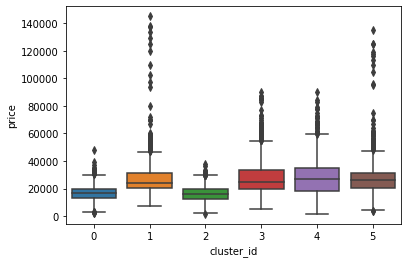

In [292]:
sns.boxplot(data=df, y="price",x="cluster_id")

Nejlevnější clustery jsou 0. a 2. ostatní jsou si podobné s tím, že v 1. a 5. jsou nejdražší auta.

## Rok registrace auta podle clusterů

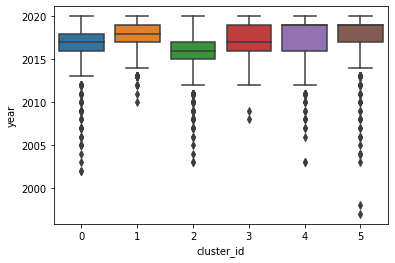

In [293]:
sns.boxplot(data=df, y="year",x="cluster_id")

Starší auta jsou v 0. a 2. clustery ty jsou také nejlevnější. V 5. jsou pak ty úplně nejstarší.

## Počet najetých mil podle clusterů

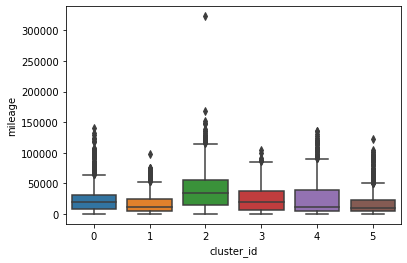

In [294]:
sns.boxplot(data=df, y="mileage",x="cluster_id")

Nejvíce najeto má 2. cluster, který patří mezi ty nejlevnější. Málo má 1. a 5,kde jsou ta dražší auta.

## Silniční daň podle clusterů

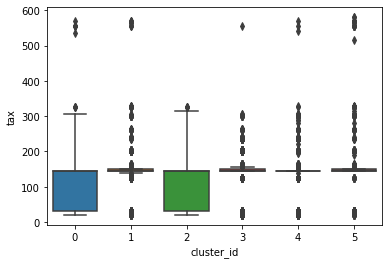

In [295]:
sns.boxplot(data=df, y="tax",x="cluster_id")

Nejmenší daň má 0. a 2. cluster, což jsou ta nejlevnější auta. U ostatních to je pak podobné.

## Velikost motoru podle clusterů

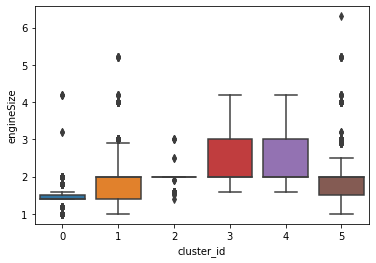

In [297]:
sns.boxplot(data=df, y="engineSize",x="cluster_id")

Nejmenší velikost motoru má 0. cluster. Ve 2. jsou do velikosti 3l. Ve 3. a 4. pak ty, která mají od 2l do 4l. V 1. a 5. jsou pak auta s více jak 5l.

## Typy paliv v clusterech

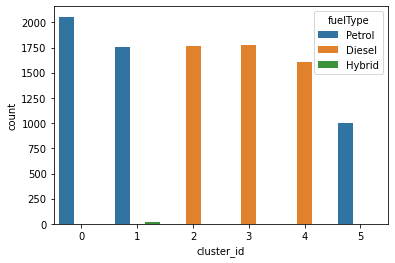

In [298]:
sns.countplot(data=df, x="cluster_id", hue="fuelType")

V 0. 1. a 5. jsou auta benzínová a v 1. jsou jestě všechny hybridy. Ve 2. 3. a 4. jsou auta naftová.

## Typy převodovek v clusterech

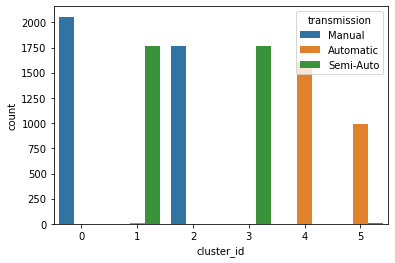

In [299]:
sns.countplot(data=df, x="cluster_id", hue="transmission")

V 0. jsou auta s manuálem a benzínová. V 1. s poloautomatem a benzínová. Ve 2. auta s manuálem a naftová. 3. poloatomat s naftovou. 4. je automat s naftou a 5. automat s benzínem.

## Závěr
Kmeans
- Po Předzpracování dat mi pomocí Elbow metody vyšel počet clusterů 6.
-  V 0. clusteru jsou nejlevnější auta, patří mezi ty starší, ale ne s moc vysokým nájezdem. Silniční daň patři mezi ty nejlevnější. Velikost motoru převážně do 1,5l. Modely aut levnější jako A1,A3. Všechna auta jsou **benzínová** a s **manuální** převodovkou.
- V 1. 2. 3.  jsou si cenově podobné ale...
- V 1. je **automat** na **naftu**. 
- V 2. je **poloautomat** na **naftu** 
- ve 3. **poloautomat** na **benzín**.
- V 4. je podobný jako ten 0. ale jsou tam auta **naftová** s **manuálem**.
- V 5. jsou dražší auta ale i nejstarší nejspíš veteráni. Cenu jistě ovlivňuje velikost motorů, jsou tady pěti a šestilitry. Jsou tady auta s **automatickou** převodovkou a na **benzín**.

Vidíme, že to co rozhodovalo nejvíce bylo typ převodovky a druh paliva.

Agglomerative clustering
- Také mi vošlo 6 clusterů a data jsou si podobná
- Tady to rozhodovalo podle stejných kritériích ale s tím, že clustery měli jiné číslo